# Analysis of Noise-Perturbed Student-Teacher Network

This notebook analyses the results from the grid search over noise levels in the feedforward noisy units experiment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import glob
from IPython.display import Image, display


plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.dpi"] = 100

In [2]:
# Path to grid search results
grid_search_dir = Path(
    "/tungstenfs/scratch/gzenke/bedfrory/dp-simulations/noisy-weights/varying-noise"
)

# Find all run directories
run_dirs = sorted(
    [d for d in grid_search_dir.iterdir() if d.is_dir() and d.name.startswith("noise-")]
)
print(f"Found {len(run_dirs)} runs:")
for d in run_dirs:
    print(f"  {d.name}")

Found 10 runs:
  noise-0.05
  noise-0.10
  noise-0.15
  noise-0.20
  noise-0.25
  noise-0.30
  noise-0.35
  noise-0.40
  noise-0.45
  noise-0.50


In [3]:
# Extract noise levels and load final metrics from each run
results = []

for run_dir in run_dirs:
    # Extract noise fraction from directory name (now "noise-X" format)
    match = re.search(r"noise-([\d.]+)", run_dir.name)
    if match:
        noise_fraction = float(match.group(1))
    else:
        continue

    # Load training metrics
    metrics_path = run_dir / "training_metrics.csv"
    if not metrics_path.exists():
        print(f"Warning: {metrics_path} not found, skipping")
        continue

    df = pd.read_csv(metrics_path)

    # Get final row (last epoch)
    final_row = df.iloc[-1]

    # New flattened column names: scaling_factors/X_value instead of scaling_factors/X/value
    results.append(
        {
            "noise_fraction": noise_fraction,
            "final_epoch": final_row["epoch"],
            # Scaling factors - learned values (normalized so target=1)
            "exc_to_exc_value": final_row[
                "scaling_factors/excitatory_to_excitatory_value"
            ],
            "exc_to_inh_value": final_row[
                "scaling_factors/excitatory_to_inhibitory_value"
            ],
            "inh_to_exc_value": final_row[
                "scaling_factors/inhibitory_to_excitatory_value"
            ],
            "inh_to_inh_value": final_row[
                "scaling_factors/inhibitory_to_inhibitory_value"
            ],
            "mitral_to_exc_value": final_row[
                "scaling_factors/mitral_to_excitatory_value"
            ],
            "mitral_to_inh_value": final_row[
                "scaling_factors/mitral_to_inhibitory_value"
            ],
            # Scaling factors - targets (should all be 1.0 now)
            "exc_to_exc_target": final_row[
                "scaling_factors/excitatory_to_excitatory_target"
            ],
            "exc_to_inh_target": final_row[
                "scaling_factors/excitatory_to_inhibitory_target"
            ],
            "inh_to_exc_target": final_row[
                "scaling_factors/inhibitory_to_excitatory_target"
            ],
            "inh_to_inh_target": final_row[
                "scaling_factors/inhibitory_to_inhibitory_target"
            ],
            "mitral_to_exc_target": final_row[
                "scaling_factors/mitral_to_excitatory_target"
            ],
            "mitral_to_inh_target": final_row[
                "scaling_factors/mitral_to_inhibitory_target"
            ],
            # Firing rates - student and teacher
            "student_firing_rate_mean": final_row["firing_rate/student_mean"],
            "student_firing_rate_exc": final_row["firing_rate/student_excitatory_mean"],
            "student_firing_rate_inh": final_row["firing_rate/student_inhibitory_mean"],
            "teacher_firing_rate_mean": final_row["firing_rate/teacher_mean"],
            "teacher_firing_rate_exc": final_row["firing_rate/teacher_excitatory_mean"],
            "teacher_firing_rate_inh": final_row["firing_rate/teacher_inhibitory_mean"],
            # Loss
            "final_loss": final_row["total_loss"],
        }
    )

results_df = pd.DataFrame(results).sort_values("noise_fraction").reset_index(drop=True)
print(f"\nLoaded results from {len(results_df)} runs")
results_df


Loaded results from 10 runs


,noise_fraction,final_epoch,exc_to_exc_value,exc_to_inh_value,inh_to_exc_value,inh_to_inh_value,mitral_to_exc_value,mitral_to_inh_value,exc_to_exc_target,exc_to_inh_target,...,inh_to_inh_target,mitral_to_exc_target,mitral_to_inh_target,student_firing_rate_mean,student_firing_rate_exc,student_firing_rate_inh,teacher_firing_rate_mean,teacher_firing_rate_exc,teacher_firing_rate_inh,final_loss
0,0.05,1000.0,1.002356,1.012324,0.990682,0.994696,0.999626,1.005482,1.0,1.0,...,1.0,1.0,1.0,1.16388,0.534200,3.6826,1.1591,0.528825,3.6802,0.702007
1,0.10,1000.0,0.999136,1.014608,0.983907,0.992942,0.997105,1.002395,1.0,1.0,...,1.0,1.0,1.0,1.16770,0.538200,3.6857,1.1591,0.528825,3.6802,1.416816
2,0.15,1000.0,0.990255,1.001079,0.979288,0.998456,0.990016,0.994114,1.0,1.0,...,1.0,1.0,1.0,1.16940,0.539550,3.6888,1.1591,0.528825,3.6802,2.141258
3,0.20,1000.0,0.973662,0.973667,0.976368,1.001211,0.981191,0.970535,1.0,1.0,...,1.0,1.0,1.0,1.16972,0.541225,3.6837,1.1591,0.528825,3.6802,2.919973
4,0.25,1000.0,0.948942,0.941153,0.972588,1.003773,0.968195,0.933513,1.0,1.0,...,1.0,1.0,1.0,1.16900,0.541150,3.6804,1.1591,0.528825,3.6802,3.770496
5,0.30,1000.0,0.919084,0.903109,0.969144,0.997262,0.951075,0.888870,1.0,1.0,...,1.0,1.0,1.0,1.16818,0.541450,3.6751,1.1591,0.528825,3.6802,4.711557
6,0.35,1000.0,0.884407,0.852029,0.961657,0.991389,0.922889,0.832407,1.0,1.0,...,1.0,1.0,1.0,1.16226,0.540000,3.6513,1.1591,0.528825,3.6802,5.743649
7,0.40,1000.0,0.842829,0.804123,0.950217,0.986560,0.893853,0.777500,1.0,1.0,...,1.0,1.0,1.0,1.15640,0.536650,3.6354,1.1591,0.528825,3.6802,6.870010
8,0.45,1000.0,0.799146,0.751986,0.936383,0.975406,0.862886,0.729061,1.0,1.0,...,1.0,1.0,1.0,1.14942,0.533175,3.6144,1.1591,0.528825,3.6802,8.046754
9,0.50,1000.0,0.756239,0.709033,0.919200,0.957651,0.830003,0.680589,1.0,1.0,...,1.0,1.0,1.0,1.13794,0.528575,3.5754,1.1591,0.528825,3.6802,9.142648


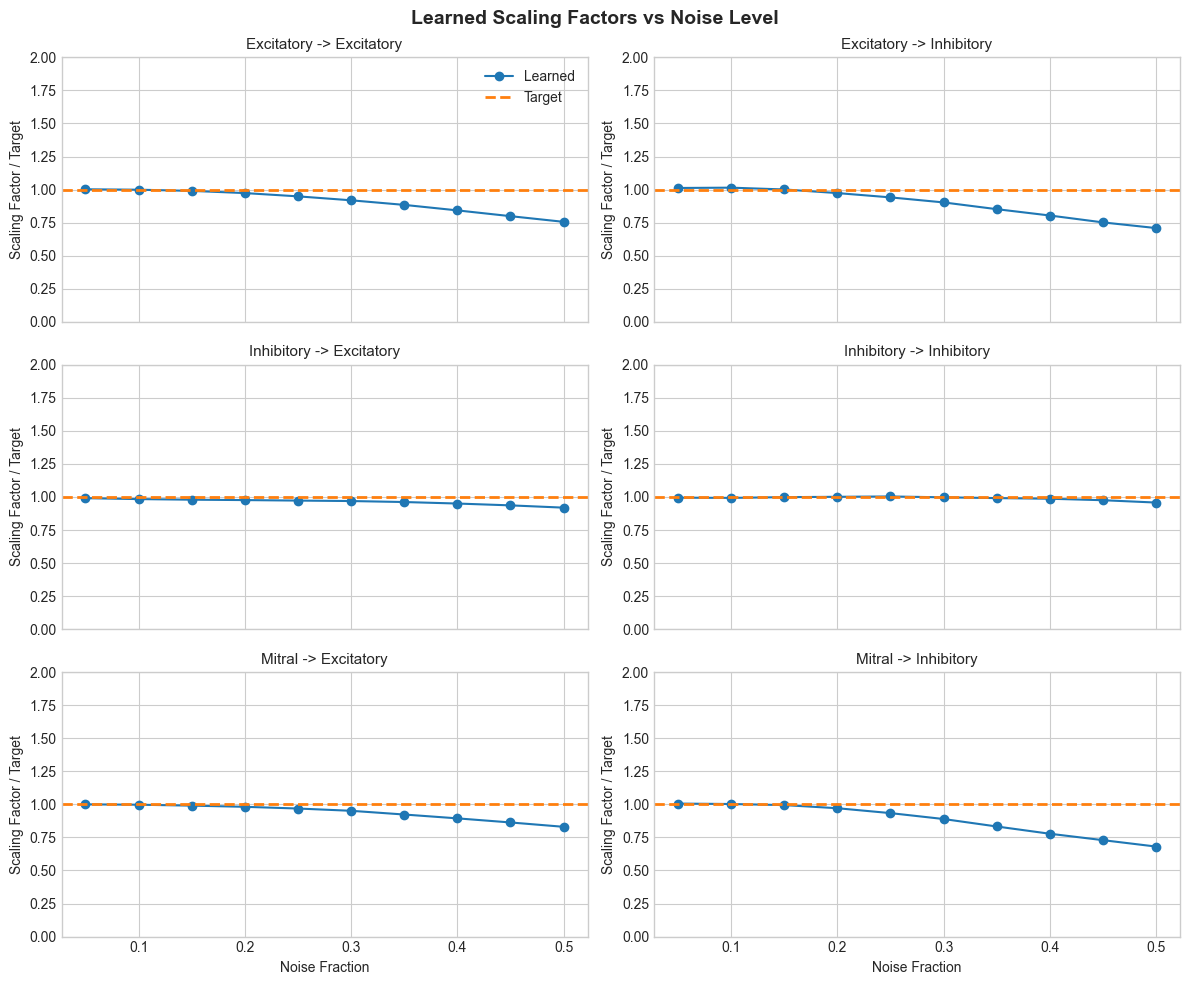

In [4]:
# Plot learned scaling factors vs noise level (3x2 subplot)
# Since targets are now normalized to 1.0, we plot value directly
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)

scaling_factor_pairs = [
    ("exc_to_exc", "Excitatory -> Excitatory"),
    ("exc_to_inh", "Excitatory -> Inhibitory"),
    ("inh_to_exc", "Inhibitory -> Excitatory"),
    ("inh_to_inh", "Inhibitory -> Inhibitory"),
    ("mitral_to_exc", "Mitral -> Excitatory"),
    ("mitral_to_inh", "Mitral -> Inhibitory"),
]

noise_levels = results_df["noise_fraction"].values

for idx, (key, title) in enumerate(scaling_factor_pairs):
    ax = axes.flat[idx]

    # Get values (already normalized so target=1)
    values = results_df[f"{key}_value"].values

    # Plot learned values
    ax.plot(noise_levels, values, "o-", color="C0", label="Learned", markersize=6)

    # Plot target line at 1.0
    ax.axhline(y=1.0, color="C1", linestyle="--", linewidth=2, label="Target")

    ax.set_title(title, fontsize=11)
    ax.set_ylabel("Scaling Factor / Target")
    ax.set_ylim(0, 2)

    if idx >= 4:  # Bottom row
        ax.set_xlabel("Noise Fraction")

    if idx == 0:
        ax.legend(loc="best")

plt.suptitle("Learned Scaling Factors vs Noise Level", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [5]:
# Scatter plot of teacher vs perturbed weights for noise_frac = 0.4
noise_level_to_plot = 0.40
run_dir = grid_search_dir / f"noise-{noise_level_to_plot:.2f}"

# Load teacher weights (from symlinked input)
teacher_data = np.load(run_dir / "inputs" / "network_structure.npz")
teacher_ff_weights = teacher_data["feedforward_weights"]  # (1500, 5000)
teacher_rec_weights = teacher_data["recurrent_weights"]  # (5000, 5000)

# Concatenate to match the training script's format
teacher_weights = np.concatenate(
    [teacher_ff_weights, teacher_rec_weights], axis=0
)  # (6500, 5000)

# Load noise config to get seed
noise_config = np.load(run_dir / "targets" / "weight_noise_config.npz")
noise_frac = float(noise_config["noise_frac"])
seed = int(noise_config["seed"])

print(f"Noise fraction: {noise_frac}")
print(f"Seed: {seed}")
print(f"Teacher weights shape: {teacher_weights.shape}")


# Apply the same noise function used in training (affine transformation approach)
def apply_noise_affine(weights, noise_frac, rng=None):
    """Apply multiplicative noise with affine correction to preserve mean and std.

    This clips at 0, then rescales non-zero weights to match original statistics.
    """
    if rng is None:
        rng = np.random.default_rng()

    # Compute original statistics (on non-zero weights only)
    nonzero_mask = weights != 0
    if not nonzero_mask.any():
        return weights.copy()

    orig_mean = weights[nonzero_mask].mean()
    orig_std = weights[nonzero_mask].std()

    # Apply multiplicative noise
    multiplier = 1 + noise_frac * rng.standard_normal(weights.shape)
    multiplier = np.clip(multiplier, 0, None)  # Clip at 0
    noisy_weights = weights * multiplier

    # Rescale non-zero weights to match original mean and std
    noisy_nonzero = noisy_weights[nonzero_mask]
    noisy_mean = noisy_nonzero.mean()
    noisy_std = noisy_nonzero.std()

    if noisy_std > 0:
        # Affine transformation: (x - noisy_mean) / noisy_std * orig_std + orig_mean
        noisy_weights[nonzero_mask] = (
            noisy_nonzero - noisy_mean
        ) / noisy_std * orig_std + orig_mean

    return noisy_weights


# Reconstruct the noisy weights
weight_noise_rng = np.random.default_rng(seed)
perturbed_weights = apply_noise_affine(
    teacher_weights, noise_frac, rng=weight_noise_rng
)

print(f"Perturbed weights shape: {perturbed_weights.shape}")

Noise fraction: 0.4
Seed: 44
Teacher weights shape: (6500, 5000)
Perturbed weights shape: (6500, 5000)


Number of non-zero weights: 1,852,500
Subsampled to 50,000 points for plotting


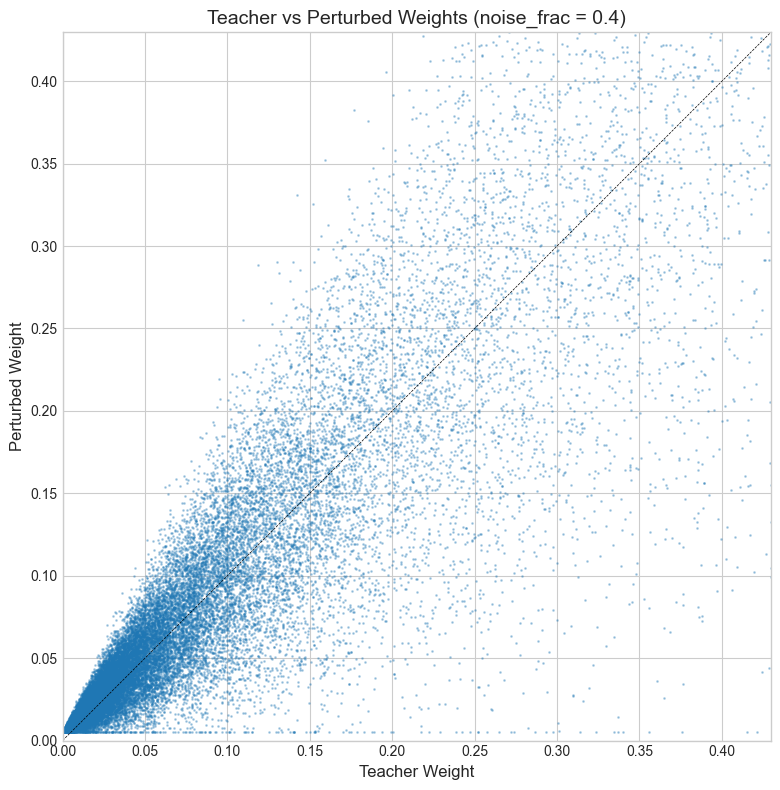


Weight statistics:
  Teacher mean: 0.1043, std: 0.3254
  Perturbed mean: 0.1043, std: 0.3254
  Correlation: 0.9155


In [6]:
# Scatter plot: Teacher vs Perturbed weights
# Only plot non-zero weights (where connections exist)
mask = teacher_weights != 0
teacher_flat = teacher_weights[mask]
perturbed_flat = perturbed_weights[mask]

print(f"Number of non-zero weights: {len(teacher_flat):,}")

# Subsample for plotting if too many points
max_points = 50000
if len(teacher_flat) > max_points:
    idx = np.random.choice(len(teacher_flat), max_points, replace=False)
    teacher_sample = teacher_flat[idx]
    perturbed_sample = perturbed_flat[idx]
    print(f"Subsampled to {max_points:,} points for plotting")
else:
    teacher_sample = teacher_flat
    perturbed_sample = perturbed_flat

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(teacher_sample, perturbed_sample, alpha=0.3, s=1, c="C0")

# Use 95th percentile for axis limits
upper_lim = np.percentile(np.concatenate([teacher_flat, perturbed_flat]), 95)
lims = [0, upper_lim]

ax.plot(lims, lims, "k--", linewidth=0.5)

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Teacher Weight", fontsize=12)
ax.set_ylabel("Perturbed Weight", fontsize=12)
ax.set_title(f"Teacher vs Perturbed Weights (noise_frac = {noise_frac})", fontsize=14)
ax.set_aspect("equal")

plt.tight_layout()
plt.show()

# Print some statistics
print("\nWeight statistics:")
print(f"  Teacher mean: {teacher_flat.mean():.4f}, std: {teacher_flat.std():.4f}")
print(f"  Perturbed mean: {perturbed_flat.mean():.4f}, std: {perturbed_flat.std():.4f}")
print(f"  Correlation: {np.corrcoef(teacher_flat, perturbed_flat)[0, 1]:.4f}")

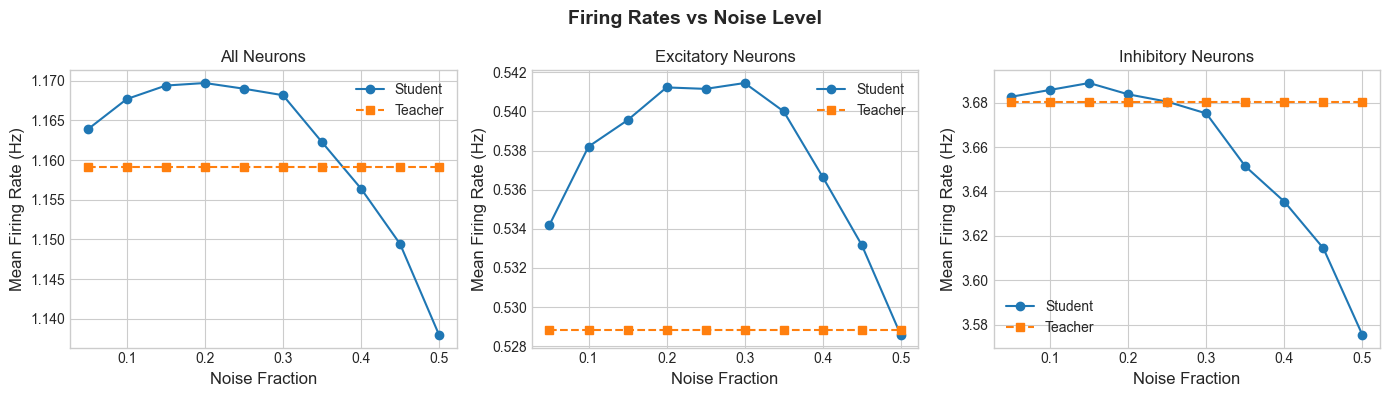


Firing rate summary at lowest noise (0.05):
  Student: all=1.16, exc=0.53, inh=3.68 Hz
  Teacher: all=1.16, exc=0.53, inh=3.68 Hz


In [7]:
# Plot firing rate vs noise level (student and teacher, by cell type)
# Now we have teacher firing rates logged in the metrics directly

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Overall mean firing rate
ax = axes[0]
ax.plot(
    results_df["noise_fraction"],
    results_df["student_firing_rate_mean"],
    "o-",
    color="C0",
    markersize=6,
    label="Student",
)
ax.plot(
    results_df["noise_fraction"],
    results_df["teacher_firing_rate_mean"],
    "s--",
    color="C1",
    markersize=6,
    label="Teacher",
)
ax.set_xlabel("Noise Fraction", fontsize=12)
ax.set_ylabel("Mean Firing Rate (Hz)", fontsize=12)
ax.set_title("All Neurons", fontsize=12)
ax.legend(loc="best")

# Excitatory neurons
ax = axes[1]
ax.plot(
    results_df["noise_fraction"],
    results_df["student_firing_rate_exc"],
    "o-",
    color="C0",
    markersize=6,
    label="Student",
)
ax.plot(
    results_df["noise_fraction"],
    results_df["teacher_firing_rate_exc"],
    "s--",
    color="C1",
    markersize=6,
    label="Teacher",
)
ax.set_xlabel("Noise Fraction", fontsize=12)
ax.set_ylabel("Mean Firing Rate (Hz)", fontsize=12)
ax.set_title("Excitatory Neurons", fontsize=12)
ax.legend(loc="best")

# Inhibitory neurons
ax = axes[2]
ax.plot(
    results_df["noise_fraction"],
    results_df["student_firing_rate_inh"],
    "o-",
    color="C0",
    markersize=6,
    label="Student",
)
ax.plot(
    results_df["noise_fraction"],
    results_df["teacher_firing_rate_inh"],
    "s--",
    color="C1",
    markersize=6,
    label="Teacher",
)
ax.set_xlabel("Noise Fraction", fontsize=12)
ax.set_ylabel("Mean Firing Rate (Hz)", fontsize=12)
ax.set_title("Inhibitory Neurons", fontsize=12)
ax.legend(loc="best")

plt.suptitle("Firing Rates vs Noise Level", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Print summary
print("\nFiring rate summary at lowest noise (0.05):")
row = results_df[results_df["noise_fraction"] == 0.05].iloc[0]
print(
    f"  Student: all={row['student_firing_rate_mean']:.2f}, exc={row['student_firing_rate_exc']:.2f}, inh={row['student_firing_rate_inh']:.2f} Hz"
)
print(
    f"  Teacher: all={row['teacher_firing_rate_mean']:.2f}, exc={row['teacher_firing_rate_exc']:.2f}, inh={row['teacher_firing_rate_inh']:.2f} Hz"
)

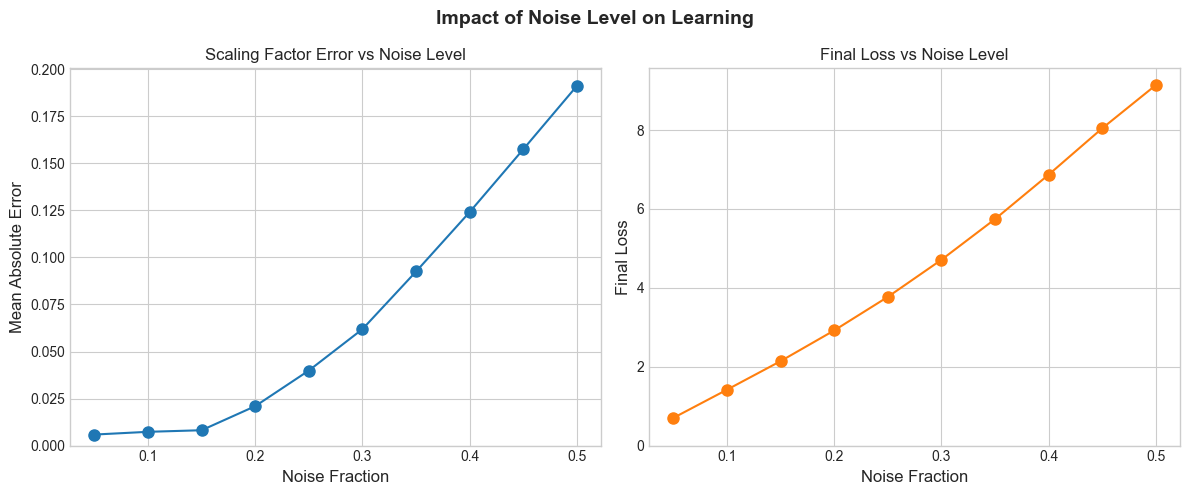


Correlation between noise and final loss: 0.9957


In [8]:
# Summary: Final scaling factor errors vs noise level
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Mapping from long names to short names used in results_df
sf_short_names = [
    "exc_to_exc",
    "exc_to_inh",
    "inh_to_exc",
    "inh_to_inh",
    "mitral_to_exc",
    "mitral_to_inh",
]

# Left: Mean absolute error of scaling factors vs noise level
ax = axes[0]
errors_by_noise = []
for _, row in results_df.iterrows():
    errors = []
    for sf_short in sf_short_names:
        error = abs(row[f"{sf_short}_value"] - 1.0)
        errors.append(error)
    errors_by_noise.append(np.mean(errors))

ax.plot(results_df["noise_fraction"], errors_by_noise, "o-", color="C0", markersize=8)
ax.set_xlabel("Noise Fraction", fontsize=12)
ax.set_ylabel("Mean Absolute Error", fontsize=12)
ax.set_title("Scaling Factor Error vs Noise Level", fontsize=12)
ax.set_ylim(0, None)

# Right: Final loss vs noise level
ax = axes[1]
ax.plot(
    results_df["noise_fraction"],
    results_df["final_loss"],
    "o-",
    color="C1",
    markersize=8,
)
ax.set_xlabel("Noise Fraction", fontsize=12)
ax.set_ylabel("Final Loss", fontsize=12)
ax.set_title("Final Loss vs Noise Level", fontsize=12)
ax.set_ylim(0, None)

plt.suptitle("Impact of Noise Level on Learning", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Print correlation
print(
    f"\nCorrelation between noise and final loss: {np.corrcoef(results_df['noise_fraction'], results_df['final_loss'])[0, 1]:.4f}"
)

## Convergence Analysis: Different Random Initializations

This section analyses the convergence behaviour of the network when starting from the same noise level but with different random seeds for the weight perturbation. The question is: does the network converge to the correct target regardless of the random initialization?

In [9]:
# Load convergence analysis data from random seed runs
convergence_dir = Path(
    "/tungstenfs/scratch/gzenke/bedfrory/dp-simulations/noisy-weights/convergence-check"
)

# Find all seed directories
seed_dirs = sorted(
    [d for d in convergence_dir.iterdir() if d.is_dir() and d.name.startswith("seed-")]
)
print(f"Found {len(seed_dirs)} convergence check runs")

# Load trajectories from all runs
scaling_factor_names = [
    ("excitatory_to_excitatory", "Exc -> Exc"),
    ("excitatory_to_inhibitory", "Exc -> Inh"),
    ("inhibitory_to_excitatory", "Inh -> Exc"),
    ("inhibitory_to_inhibitory", "Inh -> Inh"),
    ("mitral_to_excitatory", "Mitral -> Exc"),
    ("mitral_to_inhibitory", "Mitral -> Inh"),
]

trajectories = {}
for seed_dir in seed_dirs:
    seed = int(seed_dir.name.split("-")[-1])
    metrics_path = seed_dir / "training_metrics.csv"
    if not metrics_path.exists():
        print(f"Warning: {metrics_path} not found, skipping")
        continue

    df = pd.read_csv(metrics_path)
    trajectories[seed] = {
        "epochs": df["epoch"].values,
    }

    # New flattened column names
    for sf_key, _ in scaling_factor_names:
        trajectories[seed][f"{sf_key}_value"] = df[
            f"scaling_factors/{sf_key}_value"
        ].values
        trajectories[seed][f"{sf_key}_target"] = df[
            f"scaling_factors/{sf_key}_target"
        ].values[0]

    # Also store firing rates
    trajectories[seed]["student_firing_rate_mean"] = df[
        "firing_rate/student_mean"
    ].values
    trajectories[seed]["teacher_firing_rate_mean"] = df[
        "firing_rate/teacher_mean"
    ].values
    trajectories[seed]["student_firing_rate_exc"] = df[
        "firing_rate/student_excitatory_mean"
    ].values
    trajectories[seed]["student_firing_rate_inh"] = df[
        "firing_rate/student_inhibitory_mean"
    ].values

print(f"Loaded trajectories for seeds: {sorted(trajectories.keys())}")

Found 10 convergence check runs
Loaded trajectories for seeds: [42, 43, 44, 45, 46, 47, 48, 49, 50, 51]


In [10]:
# Load and visualize the noisy weights used in convergence check
example_seed = 42
example_run_dir = convergence_dir / f"seed-{example_seed}"

# Load teacher weights
teacher_data_conv = np.load(example_run_dir / "inputs" / "network_structure.npz")
teacher_ff_weights = teacher_data_conv["feedforward_weights"]
teacher_rec_weights = teacher_data_conv["recurrent_weights"]
teacher_weights_conv = np.concatenate([teacher_ff_weights, teacher_rec_weights], axis=0)

# Load noise config
noise_config = np.load(example_run_dir / "targets" / "weight_noise_config.npz")
noise_frac_conv = float(noise_config["noise_frac"])
noise_seed = int(noise_config["seed"])

print("Convergence check weight noise:")
print(f"  Noise fraction: {noise_frac_conv}")
print(f"  Seed: {noise_seed}")
print(f"  Teacher weights shape: {teacher_weights_conv.shape}")

# Reconstruct the noisy weights using the same affine approach
weight_noise_rng = np.random.default_rng(noise_seed)
perturbed_weights_conv = apply_noise_affine(
    teacher_weights_conv, noise_frac_conv, rng=weight_noise_rng
)

print(f"Perturbed weights shape: {perturbed_weights_conv.shape}")

Convergence check weight noise:
  Noise fraction: 0.4
  Seed: 42
  Teacher weights shape: (6500, 5000)
Perturbed weights shape: (6500, 5000)


Number of non-zero weights: 1,852,500
Subsampled to 50,000 points for plotting


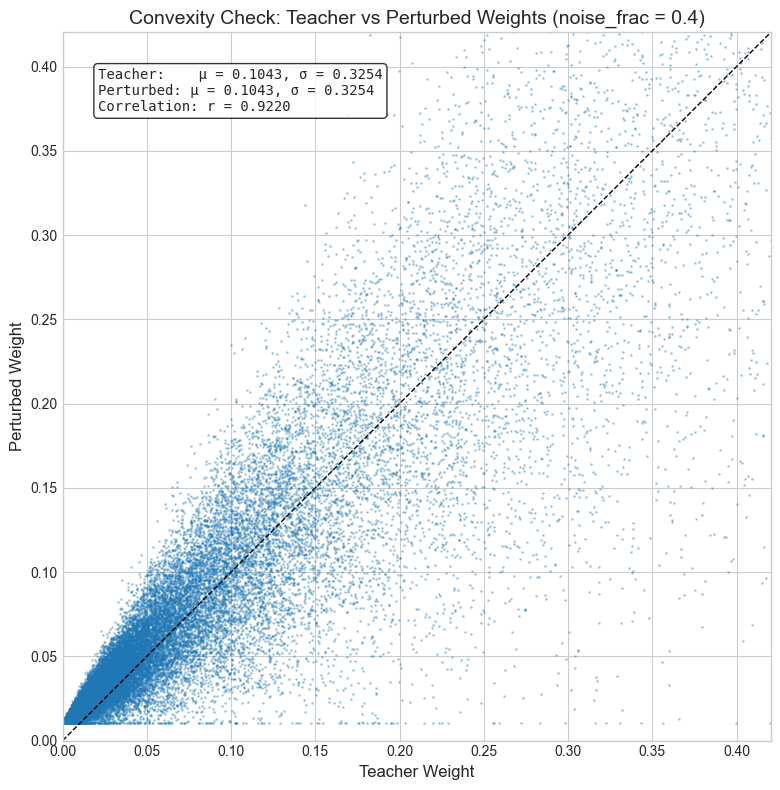

In [11]:
# Scatter plot: Teacher vs Perturbed weights with mean/std annotations
mask_conv = teacher_weights_conv != 0
teacher_flat_conv = teacher_weights_conv[mask_conv]
perturbed_flat_conv = perturbed_weights_conv[mask_conv]

print(f"Number of non-zero weights: {len(teacher_flat_conv):,}")

# Compute statistics
teacher_mean = teacher_flat_conv.mean()
teacher_std = teacher_flat_conv.std()
perturbed_mean = perturbed_flat_conv.mean()
perturbed_std = perturbed_flat_conv.std()
correlation = np.corrcoef(teacher_flat_conv, perturbed_flat_conv)[0, 1]

# Subsample for plotting
max_points = 50000
if len(teacher_flat_conv) > max_points:
    idx = np.random.choice(len(teacher_flat_conv), max_points, replace=False)
    teacher_sample_conv = teacher_flat_conv[idx]
    perturbed_sample_conv = perturbed_flat_conv[idx]
    print(f"Subsampled to {max_points:,} points for plotting")
else:
    teacher_sample_conv = teacher_flat_conv
    perturbed_sample_conv = perturbed_flat_conv

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(teacher_sample_conv, perturbed_sample_conv, alpha=0.3, s=1, c="C0")

# Use 95th percentile for axis limits
upper_lim = np.percentile(np.concatenate([teacher_flat_conv, perturbed_flat_conv]), 95)
lims = [0, upper_lim]

ax.plot(lims, lims, "k--", linewidth=1, label="Identity")

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Teacher Weight", fontsize=12)
ax.set_ylabel("Perturbed Weight", fontsize=12)
ax.set_title(
    f"Convexity Check: Teacher vs Perturbed Weights (noise_frac = {noise_frac_conv})",
    fontsize=14,
)
ax.set_aspect("equal")

# Add text box with statistics
stats_text = (
    f"Teacher:    μ = {teacher_mean:.4f}, σ = {teacher_std:.4f}\n"
    f"Perturbed: μ = {perturbed_mean:.4f}, σ = {perturbed_std:.4f}\n"
    f"Correlation: r = {correlation:.4f}"
)
ax.text(
    0.05,
    0.95,
    stats_text,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    fontfamily="monospace",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()

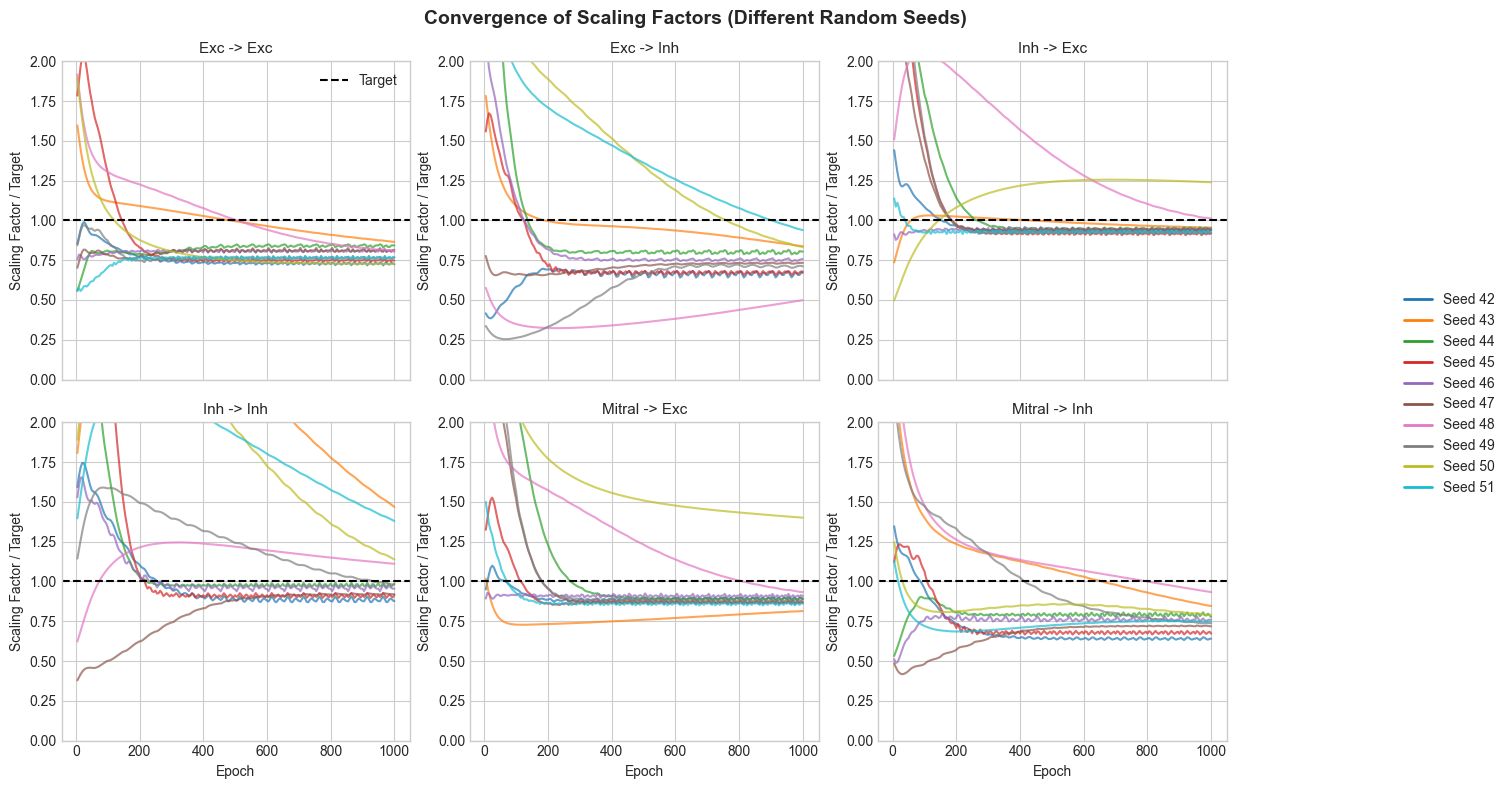

In [12]:
# Plot: Trajectories of scaling factors across all seeds
# Since targets are now normalized to 1.0, we can directly compare values
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True)

seeds = sorted(trajectories.keys())
colors = plt.cm.tab10(np.linspace(0, 1, len(seeds)))

for idx, (sf_key, sf_label) in enumerate(scaling_factor_names):
    ax = axes.flat[idx]

    for seed_idx, seed in enumerate(seeds):
        traj = trajectories[seed]
        epochs = traj["epochs"]
        values = traj[f"{sf_key}_value"]

        # Plot trajectory
        ax.plot(epochs, values, color=colors[seed_idx], alpha=0.7, linewidth=1.5)

    # Plot target line at 1.0 (all targets are normalized to 1)
    ax.axhline(y=1.0, color="black", linestyle="--", linewidth=1.5, label="Target")

    ax.set_title(sf_label, fontsize=11)
    ax.set_ylabel("Scaling Factor / Target")
    ax.set_ylim(0, 2)
    if idx >= 3:
        ax.set_xlabel("Epoch")
    if idx == 0:
        ax.legend(loc="upper right")

# Add a legend showing seed colors
handles = [
    plt.Line2D([0], [0], color=colors[i], linewidth=2) for i in range(len(seeds))
]
labels = [f"Seed {s}" for s in seeds]
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.08, 0.5))

plt.suptitle(
    "Convergence of Scaling Factors (Different Random Seeds)",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.subplots_adjust(right=0.88)
plt.show()

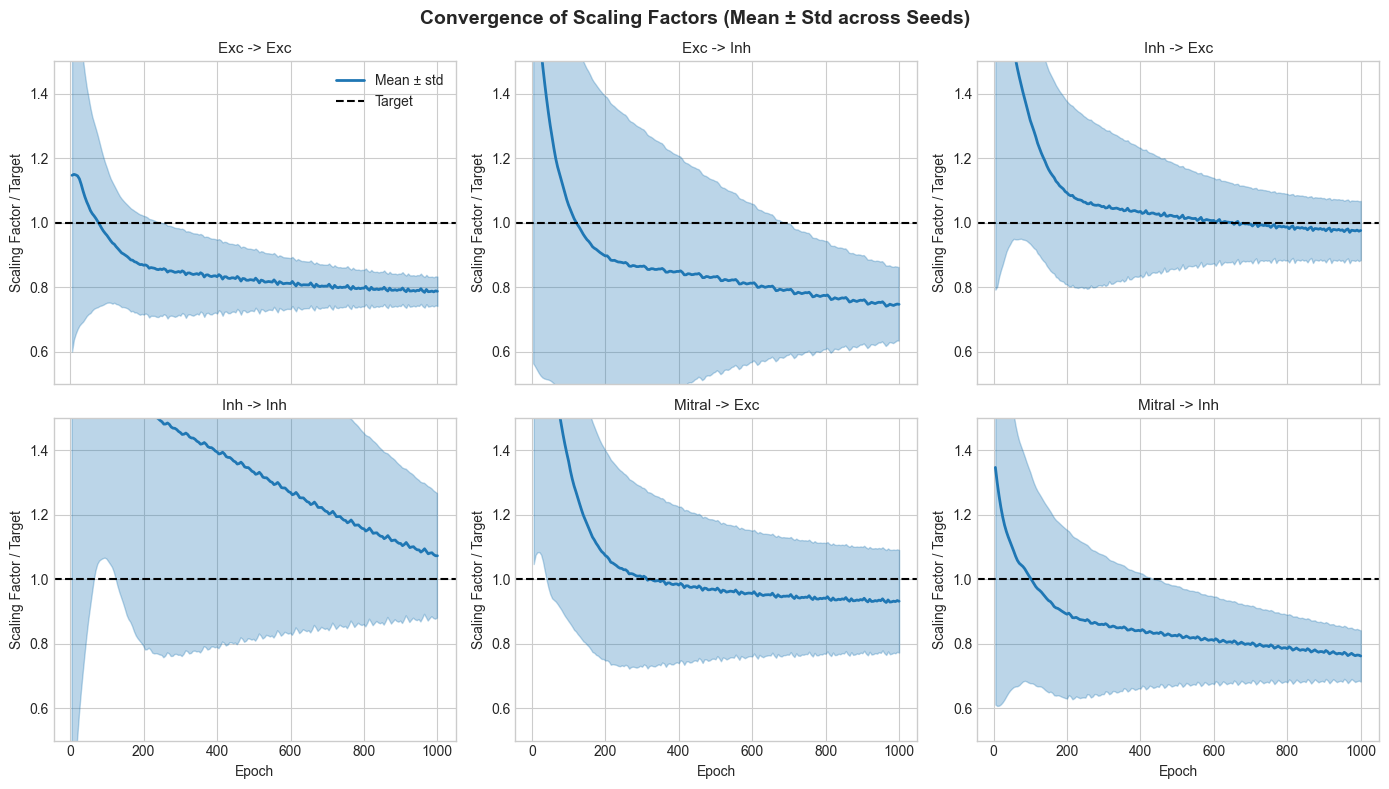

In [13]:
# Plot: Mean ± std of scaling factor trajectories across seeds
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True)

# Get common epoch grid (use the first seed's epochs as reference)
reference_seed = seeds[0]
epochs_ref = trajectories[reference_seed]["epochs"]

for idx, (sf_key, sf_label) in enumerate(scaling_factor_names):
    ax = axes.flat[idx]

    # Collect trajectories from all seeds
    all_values = []
    for seed in seeds:
        traj = trajectories[seed]
        values = traj[f"{sf_key}_value"]

        # Interpolate to reference epochs if different length
        if len(traj["epochs"]) != len(epochs_ref):
            values = np.interp(epochs_ref, traj["epochs"], values)

        all_values.append(values)

    all_values = np.array(all_values)  # (n_seeds, n_epochs)

    # Compute mean and std
    mean_traj = np.mean(all_values, axis=0)
    std_traj = np.std(all_values, axis=0)

    # Plot mean ± std
    ax.fill_between(
        epochs_ref, mean_traj - std_traj, mean_traj + std_traj, alpha=0.3, color="C0"
    )
    ax.plot(epochs_ref, mean_traj, color="C0", linewidth=2, label="Mean ± std")

    # Plot target line at 1.0
    ax.axhline(y=1.0, color="black", linestyle="--", linewidth=1.5, label="Target")

    ax.set_title(sf_label, fontsize=11)
    ax.set_ylabel("Scaling Factor / Target")
    ax.set_ylim(0.5, 1.5)
    if idx >= 3:
        ax.set_xlabel("Epoch")
    if idx == 0:
        ax.legend(loc="upper right")

plt.suptitle(
    "Convergence of Scaling Factors (Mean ± Std across Seeds)",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

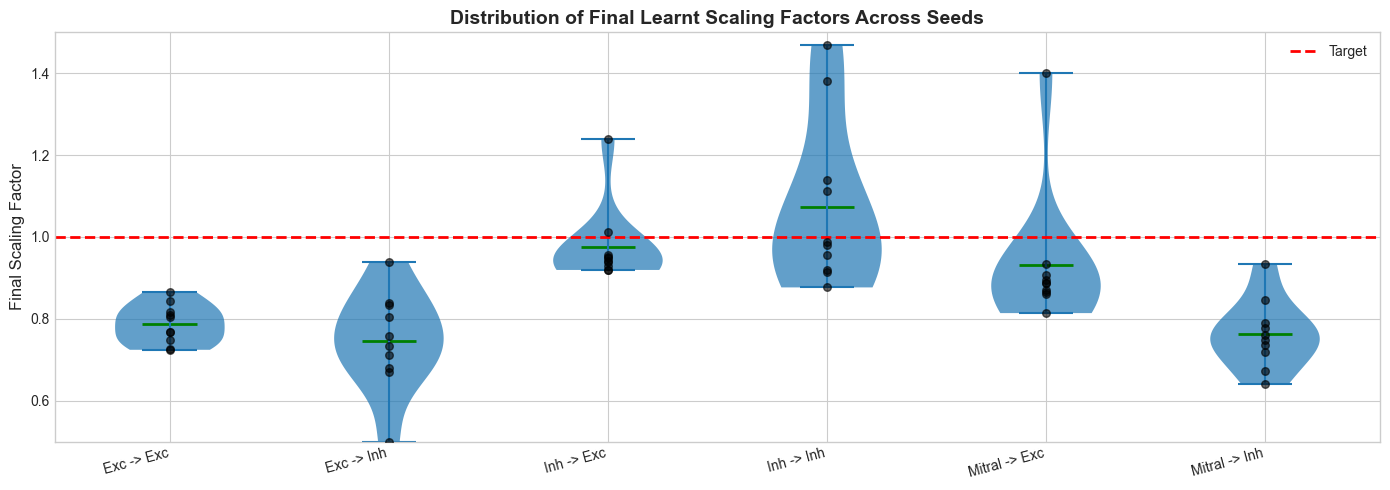


Summary Statistics (Final Scaling Factor Values):
----------------------------------------------------------------------
Exc -> Exc          : mean=0.7868, std=0.0454, min=0.7242, max=0.8650
Exc -> Inh          : mean=0.7464, std=0.1138, min=0.4987, max=0.9394
Inh -> Exc          : mean=0.9754, std=0.0917, min=0.9193, max=1.2400
Inh -> Inh          : mean=1.0732, std=0.1932, min=0.8766, max=1.4684
Mitral -> Exc       : mean=0.9321, std=0.1592, min=0.8138, max=1.4010
Mitral -> Inh       : mean=0.7623, std=0.0794, min=0.6407, max=0.9332


In [14]:
# Plot: Distribution of final learnt scaling factors as violin plot
fig, ax = plt.subplots(figsize=(14, 5))

# Collect final values for all scaling factors
violin_data = []
violin_labels = []

for sf_key, sf_label in scaling_factor_names:
    final_values = [trajectories[seed][f"{sf_key}_value"][-1] for seed in seeds]
    violin_data.append(final_values)
    violin_labels.append(sf_label)

# Create violin plot
parts = ax.violinplot(
    violin_data,
    positions=range(len(scaling_factor_names)),
    showmeans=True,
    showmedians=False,
)

# Style the violins
for pc in parts["bodies"]:
    pc.set_facecolor("C0")
    pc.set_alpha(0.7)
parts["cmeans"].set_color("green")
parts["cmeans"].set_linewidth(2)

# Add individual points
for i, data in enumerate(violin_data):
    ax.scatter([i] * len(data), data, color="black", s=30, alpha=0.6, zorder=3)

# Add target line
ax.axhline(y=1.0, color="red", linestyle="--", linewidth=2, label="Target")

# Formatting
ax.set_xticks(range(len(scaling_factor_names)))
ax.set_xticklabels(violin_labels, rotation=15, ha="right")
ax.set_ylabel("Final Scaling Factor", fontsize=12)
ax.set_ylim(0.5, 1.5)
ax.legend(loc="upper right")

plt.title(
    "Distribution of Final Learnt Scaling Factors Across Seeds",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics (Final Scaling Factor Values):")
print("-" * 70)
for i, (sf_key, sf_label) in enumerate(scaling_factor_names):
    vals = np.array(violin_data[i])
    print(
        f"{sf_label:20s}: mean={np.mean(vals):.4f}, std={np.std(vals):.4f}, "
        f"min={np.min(vals):.4f}, max={np.max(vals):.4f}"
    )

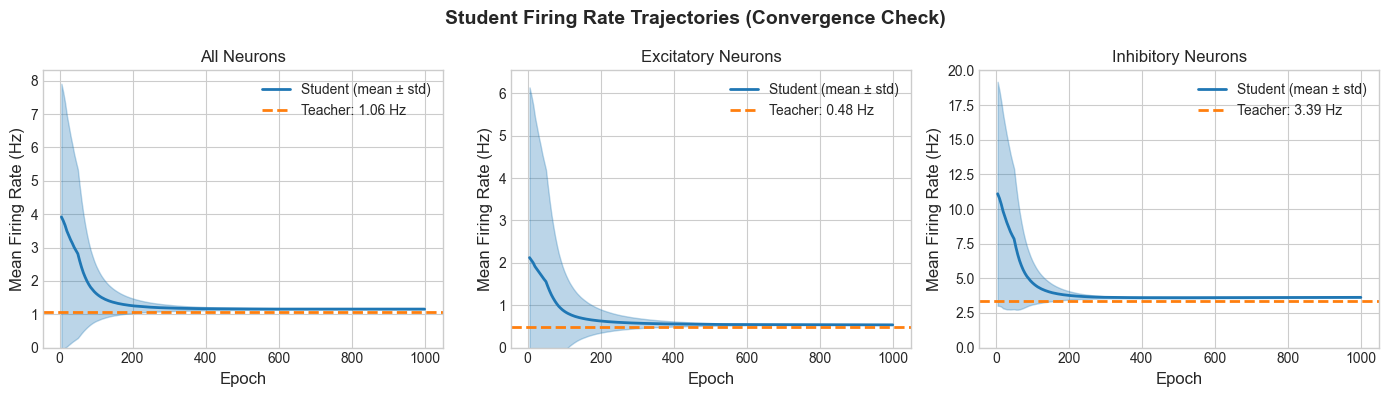

In [15]:
# Plot firing rate trajectories (mean ± std across seeds)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Collect firing rate trajectories
fr_mean_all = []
fr_exc_all = []
fr_inh_all = []

for seed in seeds:
    traj = trajectories[seed]
    epochs_seed = traj["epochs"]

    # Interpolate to common epoch grid
    fr_mean = np.interp(epochs_ref, epochs_seed, traj["student_firing_rate_mean"])
    fr_exc = np.interp(epochs_ref, epochs_seed, traj["student_firing_rate_exc"])
    fr_inh = np.interp(epochs_ref, epochs_seed, traj["student_firing_rate_inh"])

    fr_mean_all.append(fr_mean)
    fr_exc_all.append(fr_exc)
    fr_inh_all.append(fr_inh)

fr_mean_all = np.array(fr_mean_all)
fr_exc_all = np.array(fr_exc_all)
fr_inh_all = np.array(fr_inh_all)

# Get teacher firing rates (should be same across seeds)
teacher_fr_mean = trajectories[seeds[0]]["teacher_firing_rate_mean"][0]
seed_dir = convergence_dir / f"seed-{seeds[0]}"
metrics_df = pd.read_csv(seed_dir / "training_metrics.csv")
teacher_fr_exc = metrics_df["firing_rate/teacher_excitatory_mean"].iloc[0]
teacher_fr_inh = metrics_df["firing_rate/teacher_inhibitory_mean"].iloc[0]

# Plot: All neurons
ax = axes[0]
mean_traj = fr_mean_all.mean(axis=0)
std_traj = fr_mean_all.std(axis=0)
ax.fill_between(
    epochs_ref, mean_traj - std_traj, mean_traj + std_traj, alpha=0.3, color="C0"
)
ax.plot(epochs_ref, mean_traj, color="C0", linewidth=2, label="Student (mean ± std)")
ax.axhline(
    y=teacher_fr_mean,
    color="C1",
    linestyle="--",
    linewidth=2,
    label=f"Teacher: {teacher_fr_mean:.2f} Hz",
)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Mean Firing Rate (Hz)", fontsize=12)
ax.set_title("All Neurons", fontsize=12)
ax.set_ylim(0, None)
ax.legend(loc="best")

# Plot: Excitatory neurons
ax = axes[1]
mean_traj = fr_exc_all.mean(axis=0)
std_traj = fr_exc_all.std(axis=0)
ax.fill_between(
    epochs_ref, mean_traj - std_traj, mean_traj + std_traj, alpha=0.3, color="C0"
)
ax.plot(epochs_ref, mean_traj, color="C0", linewidth=2, label="Student (mean ± std)")
ax.axhline(
    y=teacher_fr_exc,
    color="C1",
    linestyle="--",
    linewidth=2,
    label=f"Teacher: {teacher_fr_exc:.2f} Hz",
)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Mean Firing Rate (Hz)", fontsize=12)
ax.set_title("Excitatory Neurons", fontsize=12)
ax.set_ylim(0, None)
ax.legend(loc="best")

# Plot: Inhibitory neurons
ax = axes[2]
mean_traj = fr_inh_all.mean(axis=0)
std_traj = fr_inh_all.std(axis=0)
ax.fill_between(
    epochs_ref, mean_traj - std_traj, mean_traj + std_traj, alpha=0.3, color="C0"
)
ax.plot(epochs_ref, mean_traj, color="C0", linewidth=2, label="Student (mean ± std)")
ax.axhline(
    y=teacher_fr_inh,
    color="C1",
    linestyle="--",
    linewidth=2,
    label=f"Teacher: {teacher_fr_inh:.2f} Hz",
)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Mean Firing Rate (Hz)", fontsize=12)
ax.set_title("Inhibitory Neurons", fontsize=12)
ax.set_ylim(0, None)
ax.legend(loc="best")

plt.suptitle(
    "Student Firing Rate Trajectories (Convergence Check)",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

## Comparison: Correct Initialisation vs Convergence Check

Compare the loss and metrics when scaling factors are initialised at their target values vs what the network learns from random initialisation.

In [ ]:
# Load correct initialisation results (training run)
correct_init_dir = Path(
    "/tungstenfs/scratch/gzenke/bedfrory/dp-simulations/noisy-weights/correct-initialisation"  # TODO: update path
)

correct_init_training_dir = correct_init_dir / "training"
correct_init_training_metrics = pd.read_csv(
    correct_init_training_dir / "training_metrics.csv"
)
correct_init_training_final = correct_init_training_metrics.iloc[-1]

print("Correct initialisation training metrics (final):")
print(f"  total_loss: {correct_init_training_final['total_loss']}")
for sf_key, sf_label in scaling_factor_names:
    print(
        f"  {sf_label}: {correct_init_training_final[f'scaling_factors/{sf_key}_value']}"
    )
print(
    f"  firing_rate/student_mean: {correct_init_training_final['firing_rate/student_mean']}"
)

Correct initialisation metrics:
  loss: 6.723827209472656
  firing_rate/student_mean: 1.7502
  firing_rate/student_std: 3.37797631134382
  firing_rate/teacher_mean: 1.1591
  firing_rate/teacher_std: 2.4857468072995688
  firing_rate/student_exc_mean: 0.72415
  firing_rate/student_inh_mean: 5.8544
  firing_rate/teacher_exc_mean: 0.5288249999999999
  firing_rate/teacher_inh_mean: 3.6802


Found 2 PNG file(s) in correct init directory

Displaying: spike_comparison.png


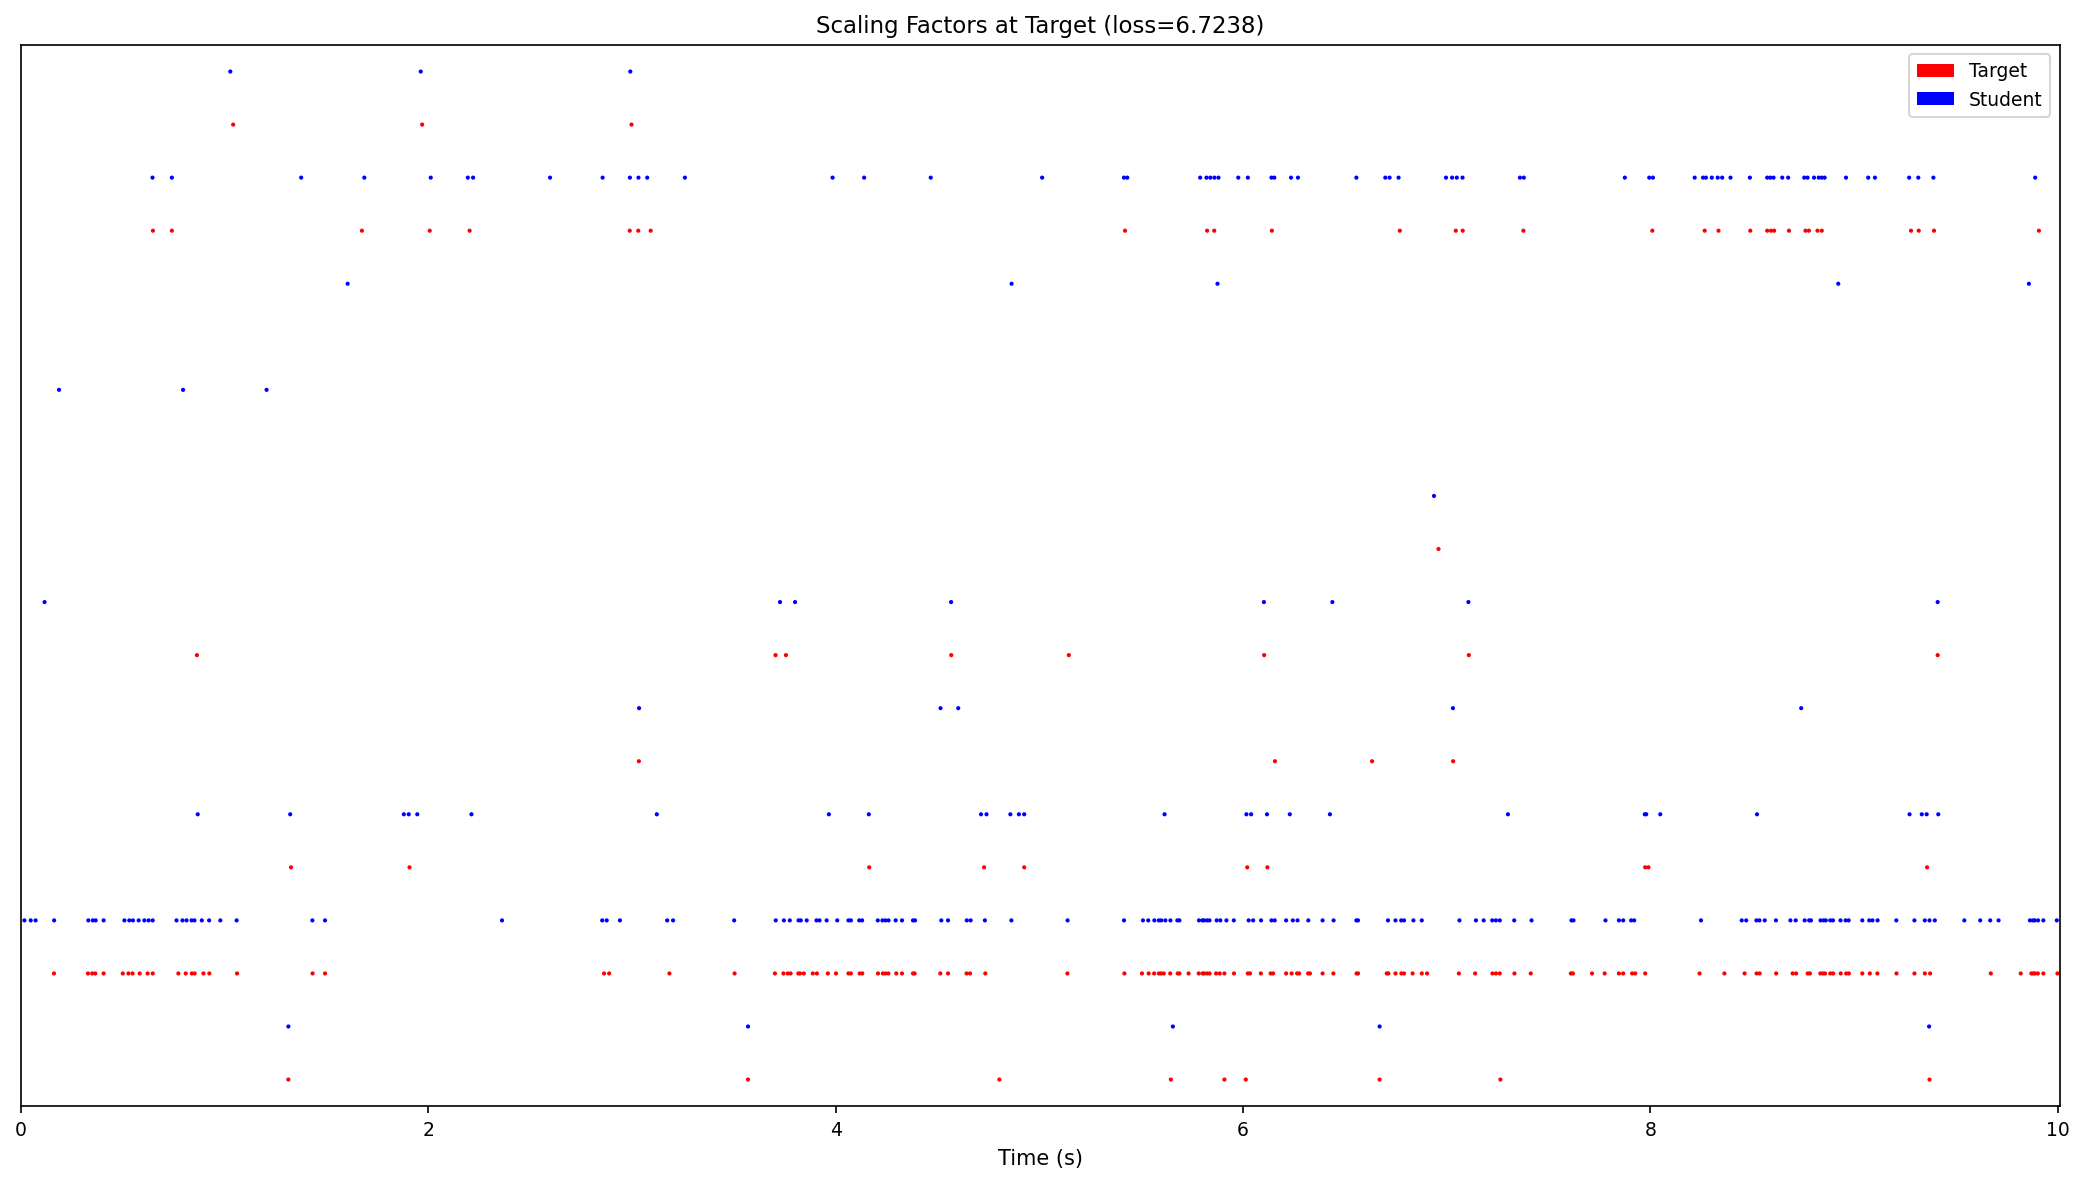


Displaying: weight_noise_comparison.png


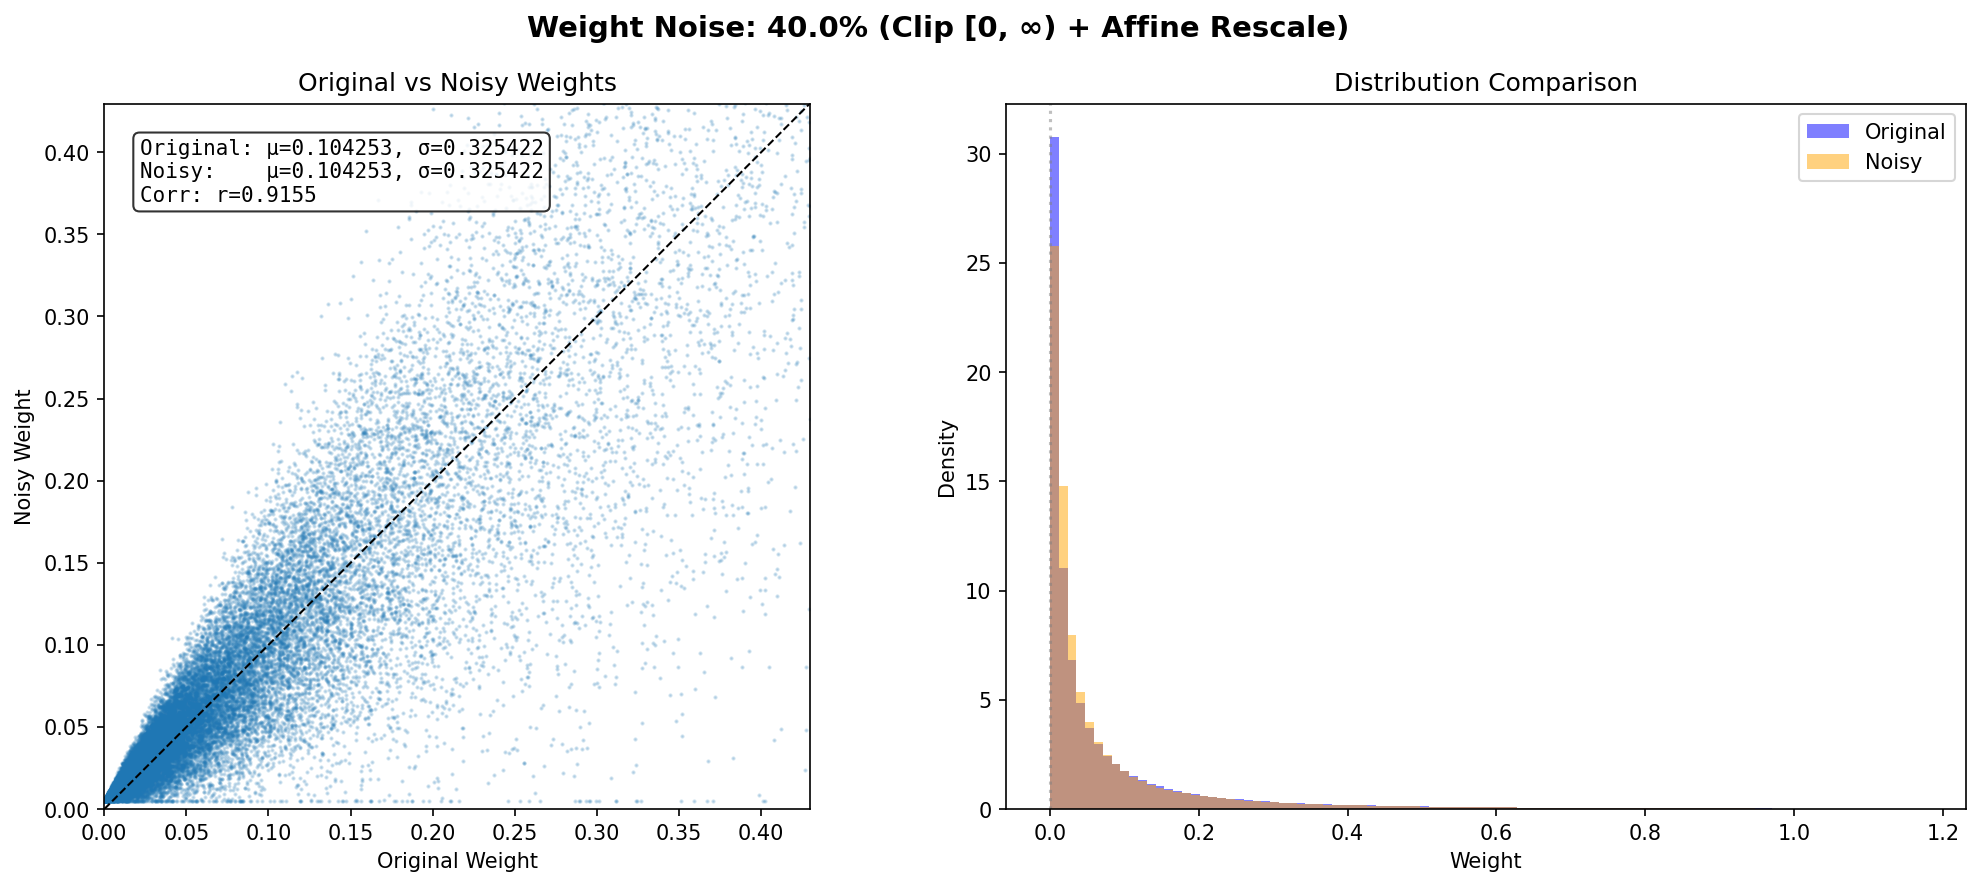

In [17]:
# Display PNG from correct initialisation
png_files = glob.glob(str(correct_init_dir / "*.png"))
print(f"Found {len(png_files)} PNG file(s) in correct init directory")

for png_file in png_files:
    print(f"\nDisplaying: {Path(png_file).name}")
    display(Image(filename=png_file))

In [18]:
# Load and visualize weights from correct initialisation
# Load teacher weights
teacher_data_correct = np.load(correct_init_dir / "inputs" / "network_structure.npz")
teacher_ff_weights_correct = teacher_data_correct["feedforward_weights"]
teacher_rec_weights_correct = teacher_data_correct["recurrent_weights"]
teacher_weights_correct = np.concatenate(
    [teacher_ff_weights_correct, teacher_rec_weights_correct], axis=0
)

# Load noise config
noise_config_correct = np.load(correct_init_dir / "targets" / "weight_noise_config.npz")
noise_frac_correct = float(noise_config_correct["noise_frac"])
noise_seed_correct = int(noise_config_correct["seed"])

print("Correct initialisation weight noise:")
print(f"  Noise fraction: {noise_frac_correct}")
print(f"  Seed: {noise_seed_correct}")
print(f"  Teacher weights shape: {teacher_weights_correct.shape}")

# Reconstruct the noisy weights using the same affine approach
weight_noise_rng_correct = np.random.default_rng(noise_seed_correct)
perturbed_weights_correct = apply_noise_affine(
    teacher_weights_correct, noise_frac_correct, rng=weight_noise_rng_correct
)

print(f"Perturbed weights shape: {perturbed_weights_correct.shape}")

Correct initialisation weight noise:
  Noise fraction: 0.4
  Seed: 44
  Teacher weights shape: (6500, 5000)
Perturbed weights shape: (6500, 5000)


Number of non-zero weights: 1,852,500
Subsampled to 50,000 points for plotting


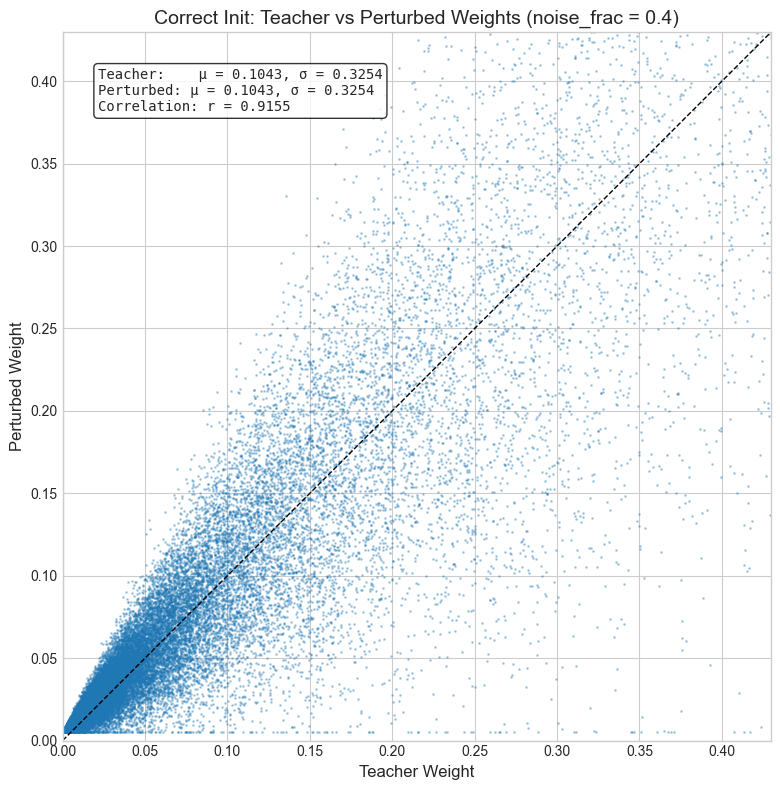

In [19]:
# Scatter plot: Teacher vs Perturbed weights with mean/std annotations (Correct Init)
mask_correct = teacher_weights_correct != 0
teacher_flat_correct = teacher_weights_correct[mask_correct]
perturbed_flat_correct = perturbed_weights_correct[mask_correct]

print(f"Number of non-zero weights: {len(teacher_flat_correct):,}")

# Compute statistics
teacher_mean_correct = teacher_flat_correct.mean()
teacher_std_correct = teacher_flat_correct.std()
perturbed_mean_correct = perturbed_flat_correct.mean()
perturbed_std_correct = perturbed_flat_correct.std()
correlation_correct = np.corrcoef(teacher_flat_correct, perturbed_flat_correct)[0, 1]

# Subsample for plotting
max_points = 50000
if len(teacher_flat_correct) > max_points:
    idx = np.random.choice(len(teacher_flat_correct), max_points, replace=False)
    teacher_sample_correct = teacher_flat_correct[idx]
    perturbed_sample_correct = perturbed_flat_correct[idx]
    print(f"Subsampled to {max_points:,} points for plotting")
else:
    teacher_sample_correct = teacher_flat_correct
    perturbed_sample_correct = perturbed_flat_correct

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(teacher_sample_correct, perturbed_sample_correct, alpha=0.3, s=1, c="C0")

# Use 95th percentile for axis limits
upper_lim = np.percentile(
    np.concatenate([teacher_flat_correct, perturbed_flat_correct]), 95
)
lims = [0, upper_lim]

ax.plot(lims, lims, "k--", linewidth=1, label="Identity")

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Teacher Weight", fontsize=12)
ax.set_ylabel("Perturbed Weight", fontsize=12)
ax.set_title(
    f"Correct Init: Teacher vs Perturbed Weights (noise_frac = {noise_frac_correct})",
    fontsize=14,
)
ax.set_aspect("equal")

# Add text box with statistics
stats_text = (
    f"Teacher:    μ = {teacher_mean_correct:.4f}, σ = {teacher_std_correct:.4f}\n"
    f"Perturbed: μ = {perturbed_mean_correct:.4f}, σ = {perturbed_std_correct:.4f}\n"
    f"Correlation: r = {correlation_correct:.4f}"
)
ax.text(
    0.05,
    0.95,
    stats_text,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    fontfamily="monospace",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()

In [ ]:
# Collect final values from incorrect initialisations (convergence check)
conv_final_losses = []
conv_final_fr_exc = []
conv_final_fr_inh = []
conv_final_fr_mean = []
conv_final_scaling = {sf_key: [] for sf_key, _ in scaling_factor_names}

for seed in seeds:
    seed_dir = convergence_dir / f"seed-{seed}"
    metrics_df = pd.read_csv(seed_dir / "training_metrics.csv")
    final_row = metrics_df.iloc[-1]

    conv_final_losses.append(final_row["total_loss"])
    conv_final_fr_mean.append(final_row["firing_rate/student_mean"])
    conv_final_fr_exc.append(final_row["firing_rate/student_excitatory_mean"])
    conv_final_fr_inh.append(final_row["firing_rate/student_inhibitory_mean"])

    for sf_key, _ in scaling_factor_names:
        conv_final_scaling[sf_key].append(final_row[f"scaling_factors/{sf_key}_value"])

conv_final_losses = np.array(conv_final_losses)
conv_final_fr_mean = np.array(conv_final_fr_mean)
conv_final_fr_exc = np.array(conv_final_fr_exc)
conv_final_fr_inh = np.array(conv_final_fr_inh)
conv_final_scaling = {key: np.array(vals) for key, vals in conv_final_scaling.items()}

# Get correct init values from training run
correct_loss = float(correct_init_training_final["total_loss"])
correct_fr_mean = float(correct_init_training_final["firing_rate/student_mean"])
correct_fr_exc = float(
    correct_init_training_final["firing_rate/student_excitatory_mean"]
)
correct_fr_inh = float(
    correct_init_training_final["firing_rate/student_inhibitory_mean"]
)
correct_scaling = {
    sf_key: float(correct_init_training_final[f"scaling_factors/{sf_key}_value"])
    for sf_key, _ in scaling_factor_names
}

print(
    f"Correct init (training) - Loss: {correct_loss:.4f}, FR: {correct_fr_mean:.2f} Hz"
)
print(
    f"Incorrect init - Loss: {conv_final_losses.mean():.4f} ± {conv_final_losses.std():.4f}"
)

Correct init - Loss: 6.7238, FR: 1.75 Hz
Convergence - Loss: 7.7230 ± 0.5135


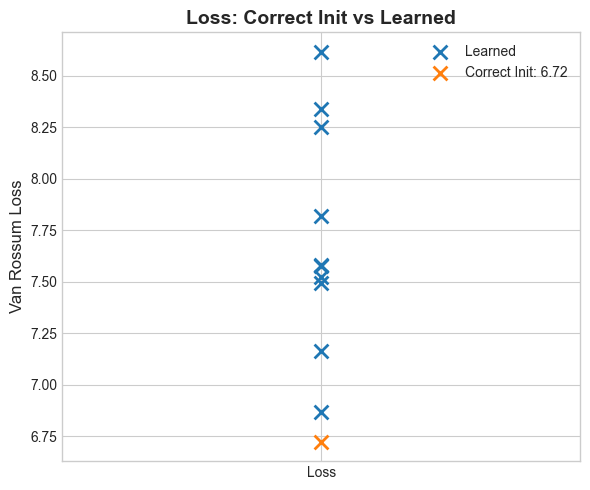


Loss comparison:
  Correct init:      6.7238
  Convergence check: 7.7230 ± 0.5135
  Difference:        0.9991 (14.9%)


In [ ]:
# Plot 2: Loss - correct init training vs incorrect init distribution
fig, ax = plt.subplots(figsize=(6, 5))

# Incorrect init values (convergence check)
ax.scatter(
    [0] * len(conv_final_losses),
    conv_final_losses,
    marker="x",
    s=100,
    color="C0",
    linewidths=2,
    label="Incorrect init",
    zorder=3,
)

# Correct init training value
ax.scatter(
    [0],
    [correct_loss],
    marker="x",
    s=100,
    color="C1",
    linewidths=2,
    label=f"Correct init (training): {correct_loss:.2f}",
    zorder=4,
)

ax.set_xticks([0])
ax.set_xticklabels(["Loss"])
ax.set_ylabel("Van Rossum Loss", fontsize=12)
ax.set_xlim(-0.5, 0.5)
ax.legend(loc="upper right")
ax.set_title(
    "Loss: Correct Init Training vs Incorrect Init", fontsize=14, fontweight="bold"
)

plt.tight_layout()
plt.show()

print("\nLoss comparison:")
print(f"  Correct init (training): {correct_loss:.4f}")
print(
    f"  Incorrect init:          {conv_final_losses.mean():.4f} ± {conv_final_losses.std():.4f}"
)
print(
    f"  Difference:              {conv_final_losses.mean() - correct_loss:.4f} ({(conv_final_losses.mean() - correct_loss) / correct_loss * 100:.1f}%)"
)

In [ ]:
# Plot 3: Scaling factors - correct init training vs incorrect init distribution
fig, ax = plt.subplots(figsize=(12, 5))

positions = np.arange(len(scaling_factor_names))

for i, (sf_key, sf_label) in enumerate(scaling_factor_names):
    data = conv_final_scaling[sf_key]
    ax.scatter(
        [i] * len(data),
        data,
        marker="x",
        s=100,
        color="C0",
        linewidths=2,
        label="Incorrect init" if i == 0 else None,
        zorder=3,
    )

correct_sf_values = [correct_scaling[sf_key] for sf_key, _ in scaling_factor_names]
ax.scatter(
    positions,
    correct_sf_values,
    marker="x",
    s=100,
    color="C1",
    linewidths=2,
    label="Correct init (training)",
    zorder=4,
)

ax.axhline(y=1.0, color="black", linestyle="--", linewidth=1.5, label="Target")
ax.set_xticks(positions)
ax.set_xticklabels(
    [label for _, label in scaling_factor_names], rotation=30, ha="right"
)
ax.set_ylabel("Scaling Factor / Target", fontsize=12)
ax.set_title(
    "Scaling Factors: Correct Init Training vs Incorrect Init",
    fontsize=14,
    fontweight="bold",
)
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

print("\nScaling factor comparison:")
print(
    f"{'Scaling Factor':<20} {'Correct Init':>12} {'Incorrect Init (mean ± std)':>28}"
)
print("-" * 65)
for sf_key, sf_label in scaling_factor_names:
    mean_val = conv_final_scaling[sf_key].mean()
    std_val = conv_final_scaling[sf_key].std()
    print(
        f"{sf_label:<20} {correct_scaling[sf_key]:>12.4f} {mean_val:>12.4f} ± {std_val:.4f}"
    )

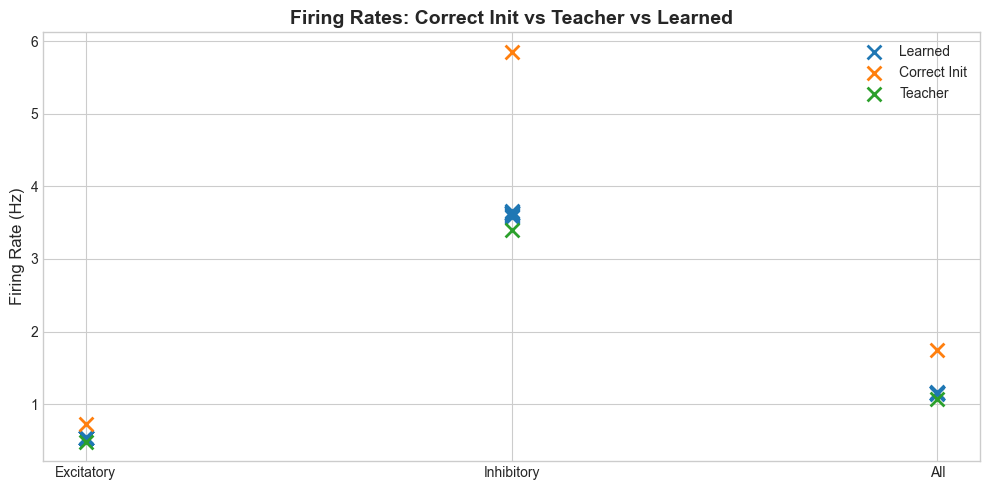


Firing rate comparison:
Cell Type    Correct Init      Teacher              Learned
------------------------------------------------------------
Excitatory          0.724        0.482      0.536 ± 0.002
Inhibitory          5.854        3.392      3.625 ± 0.023
All                 1.750        1.064      1.154 ± 0.006


In [ ]:
# Plot 4: Firing Rates by Cell Type - correct init training vs teacher vs incorrect init
fig, ax = plt.subplots(figsize=(10, 5))

# Data: [exc, inh, mean]
fr_data = [conv_final_fr_exc, conv_final_fr_inh, conv_final_fr_mean]
fr_labels = ["Excitatory", "Inhibitory", "All"]
positions = np.arange(len(fr_labels))

# Incorrect init values (convergence check)
for i, data in enumerate(fr_data):
    ax.scatter(
        [i] * len(data),
        data,
        marker="x",
        s=100,
        color="C0",
        linewidths=2,
        label="Incorrect init" if i == 0 else None,
        zorder=3,
    )

# Correct init training values
correct_fr_values = [correct_fr_exc, correct_fr_inh, correct_fr_mean]
ax.scatter(
    positions,
    correct_fr_values,
    marker="x",
    s=100,
    color="C1",
    linewidths=2,
    label="Correct init (training)",
    zorder=4,
)

# Teacher values
teacher_fr_values = [teacher_fr_exc, teacher_fr_inh, teacher_fr_mean]
ax.scatter(
    positions,
    teacher_fr_values,
    marker="x",
    s=100,
    color="C2",
    linewidths=2,
    label="Teacher",
    zorder=4,
)

ax.set_xticks(positions)
ax.set_xticklabels(fr_labels)
ax.set_ylabel("Firing Rate (Hz)", fontsize=12)
ax.legend(loc="upper right")
ax.set_title(
    "Firing Rates: Correct Init Training vs Teacher vs Incorrect Init",
    fontsize=14,
    fontweight="bold",
)

plt.tight_layout()
plt.show()

print("\nFiring rate comparison:")
print(f"{'Cell Type':<12} {'Correct Init':>12} {'Teacher':>12} {'Incorrect Init':>20}")
print("-" * 60)
print(
    f"{'Excitatory':<12} {correct_fr_exc:>12.3f} {teacher_fr_exc:>12.3f} {conv_final_fr_exc.mean():>10.3f} ± {conv_final_fr_exc.std():.3f}"
)
print(
    f"{'Inhibitory':<12} {correct_fr_inh:>12.3f} {teacher_fr_inh:>12.3f} {conv_final_fr_inh.mean():>10.3f} ± {conv_final_fr_inh.std():.3f}"
)
print(
    f"{'All':<12} {correct_fr_mean:>12.3f} {teacher_fr_mean:>12.3f} {conv_final_fr_mean.mean():>10.3f} ± {conv_final_fr_mean.std():.3f}"
)